In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.preprocessing import  image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
import os,warnings, random,shutil
warnings.filterwarnings('ignore')
import codecs
codecs.register_error("strict",codecs.ignore_errors)
from tensorflow.keras.applications import ResNet50,EfficientNetB3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


importing packages needed for image classifcation

This project aims to leverage deep learning for automatic garbage classification, sorting waste into ten distinct categories: **Metal, Glass, Biological Waste, Paper, Battery Waste, General Trash, Cardboard, Shoes, Clothes, and Plastic**. The objective is to develop a reliable image classification model capable of identifying waste items based on their visual characteristics. This system can enhance waste management efficiency and encourage more effective recycling practices.

1. Importing Required Libraries  
2. Dataset Loading  
3. Image Visualization  
4. Preprocessing Images  
5. Model Development  
   - **EfficientNetB3**  
   - **5.1 EfficientNetB3: Compilation & Training**  
6. ResNet50 Model  
   - **6.1 ResNet50: Compilation & Training**  
7. Convolutional Neural Network (CNN)  
   - **7.1 CNN: Compilation & Training**  
8. Model Performance Comparison (Accuracy & Loss)  
9. Making Predictions  
10. Predicting the First Class  
11. Conclusion & Acknowledgment

In [4]:
#loading of the dataset
data_path= data_path = "/content/drive/MyDrive/archive (9)/garbage-dataset"
classes_names=os.listdir(data_path)
classes_names

['plastic',
 'glass',
 'shoes',
 'clothes',
 'biological',
 'trash',
 'battery',
 'cardboard',
 'metal',
 'paper']

In [5]:
out_dir='/colab/working/'

train_dir=os.path.join(out_dir,'train')
valid_dir=os.path.join(out_dir,'valid')
test_dir=os.path.join(out_dir,'test')

for folder in [train_dir, valid_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

In [6]:
# Train-Validation-Test Split Ratios
train_ratio = 0.7  # 70% Training
valid_ratio = 0.15  # 15% Validation
test_ratio = 0.15   # 15% Testing

# Iterate over each class in the dataset
for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    # Get all image file names
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png',))]

    # Shuffle images
    random.shuffle(image_files)

    # Split images into train, validation, and test sets
    train_imgs, temp_imgs = train_test_split(image_files, test_size=(1 - train_ratio), random_state=42)
    valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=(test_ratio / (test_ratio + valid_ratio)), random_state=42)

    # Create class directories in train, valid, and test folders
    for folder in [train_dir, valid_dir, test_dir]:
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

    # Move images to corresponding folders
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

    for img in valid_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(valid_dir, class_name, img))

    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))

IMAGE VISUALZATION IN A RANDOM STATE

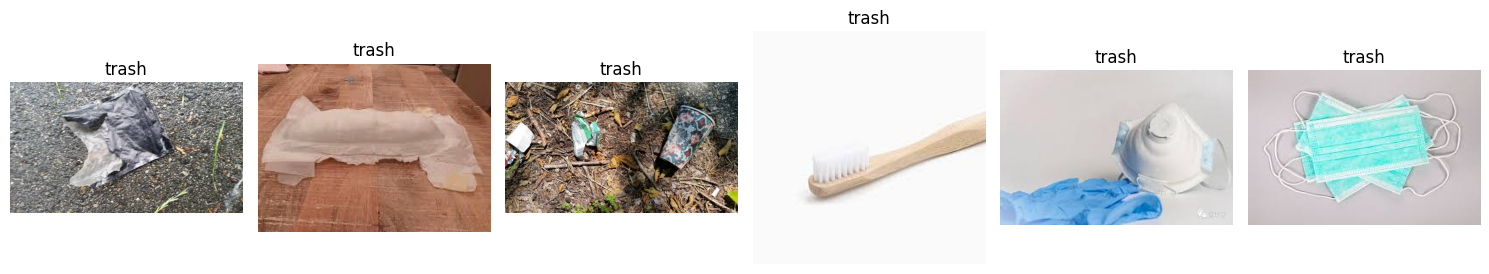

In [8]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get list of classes (folders in dataset)
classes = [cls for cls in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, cls))]

# Set number of images to display
num_images = 6

# Randomly pick a class
selected_class = random.choice(classes)
class_path = os.path.join(data_path, selected_class)

# Get list of images in the selected class
image_files = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly select images
selected_images = random.sample(image_files, min(num_images, len(image_files)))

# Plot the images
fig, axes = plt.subplots(1, len(selected_images), figsize=(15, 5))

for ax, img_name in zip(axes, selected_images):
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(selected_class)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [10]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # ResNet50 preprocessing
    # rotation_range=20,      # Randomly rotate images by up to 20 degrees
    # width_shift_range=0.2,  # Shift width by up to 20% of the image
    # height_shift_range=0.2, # Shift height by up to 20% of the image
    # shear_range=0.2,        # Shear transformation
    # zoom_range=0.3,         # Randomly zoom in on images
    # horizontal_flip=True,   # Flip images horizontally
    # fill_mode='nearest'     # Fill empty pixels after transformations
)

valid_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=100,
    class_mode='categorical'
)

# Validation Data Generator
valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=100,
    class_mode='categorical'
)

# Test Data Generator (without labels, for predictions)
test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=1,
    class_mode=None,
    shuffle=False,  # Don't shuffle test images
    seed=123
)

Found 13843 images belonging to 10 classes.
Found 2970 images belonging to 10 classes.
Found 2973 images belonging to 10 classes.


In [11]:
calss_labels=train_generator.class_indices
print(calss_labels)

{'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'paper': 6, 'plastic': 7, 'shoes': 8, 'trash': 9}


In [12]:
base_model=EfficientNetB3(include_top=False,pooling='avg',weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add new layers
x = Dense(128, activation='relu')(base_model.output)
x = Dense(64, activation='relu')(x)
output_layer = Dense(10, activation='softmax')(x)  # Adjust output neurons as needed

# Define the new model
model_1 = Model(inputs=base_model.input, outputs=output_layer)

# Print model summary
model_1.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, None, None, 3)  │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, None, None, 3)  │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 40) │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 40) │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 40) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, None, None, 40) │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, None, None, 40) │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, None, None, 40) │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,989,177 (41.92 MB)

 Trainable params: 205,642 (803.29 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [13]:
model_1.compile(optimizer='Rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class StopOnHighAccuracy(Callback):
    def __init__(self, threshold=0.90):
        super(StopOnHighAccuracy, self).__init__()
        self.threshold = threshold  # Set the accuracy threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get("accuracy")  # Get the accuracy metric

        if accuracy is not None and accuracy >= self.threshold:
            print(f"\nStopping training as accuracy reached {accuracy:.4f} at epoch {epoch + 1}")
            self.model.stop_training = True  # Stop training

# Instantiate the callback with a threshold (e.g., 99.5% accuracy)
stop_callback = StopOnHighAccuracy(threshold=0.90)



In [16]:
history_1=model_1.fit(
           train_generator,
           steps_per_epoch=train_generator.samples//100,
           validation_data=valid_generator,
           validation_steps=valid_generator.samples//100,
           epochs=20,
           callbacks=[stop_callback])

Epoch 1/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 161s 834ms/step - accuracy: 0.5327 - loss: 2.0006 - val_accuracy: 0.7128 - val_loss: 0.9341
Epoch 2/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.7000 - loss: 1.0042 - val_accuracy: 0.7231 - val_loss: 0.9097
Epoch 3/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 122s 542ms/step - accuracy: 0.6984 - loss: 1.1407 - val_accuracy: 0.7517 - val_loss: 0.7912
Epoch 4/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.7400 - loss: 0.8721 - val_accuracy: 0.7462 - val_loss: 0.7993
Epoch 5/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 127s 532ms/step - accuracy: 0.7272 - loss: 1.1617 - val_accuracy: 0.7548 - val_loss: 0.7704
Epoch 6/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - accuracy: 0.7700 - loss: 1.0197 - val_accuracy: 0.7597 - val_loss: 0.7934
Epoch 7/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 143s 640ms/step - accuracy: 0.7516 - loss: 1.0490 - val_accuracy: 0.7655 - val_loss: 0.7339
Epoch 8/20
138/138 ━━━━━━━━━━━━━━━━━━━━ 14s 104ms/step - accuracy: 0.7100 - loss: 

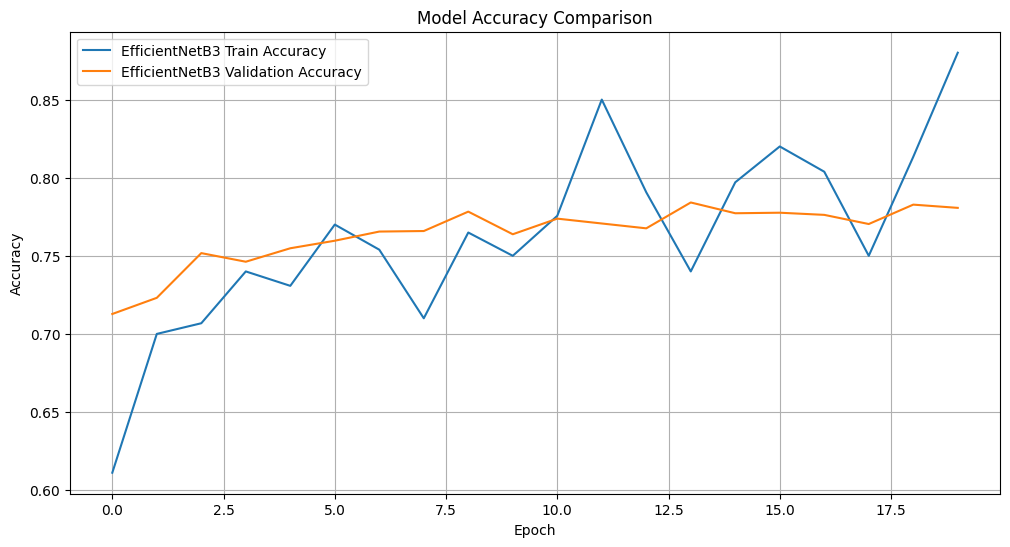

In [17]:
plt.figure(figsize=(12, 6))



#   EfficientNetB3
plt.plot(history_1.history['accuracy'], label='EfficientNetB3 Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='EfficientNetB3 Validation Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

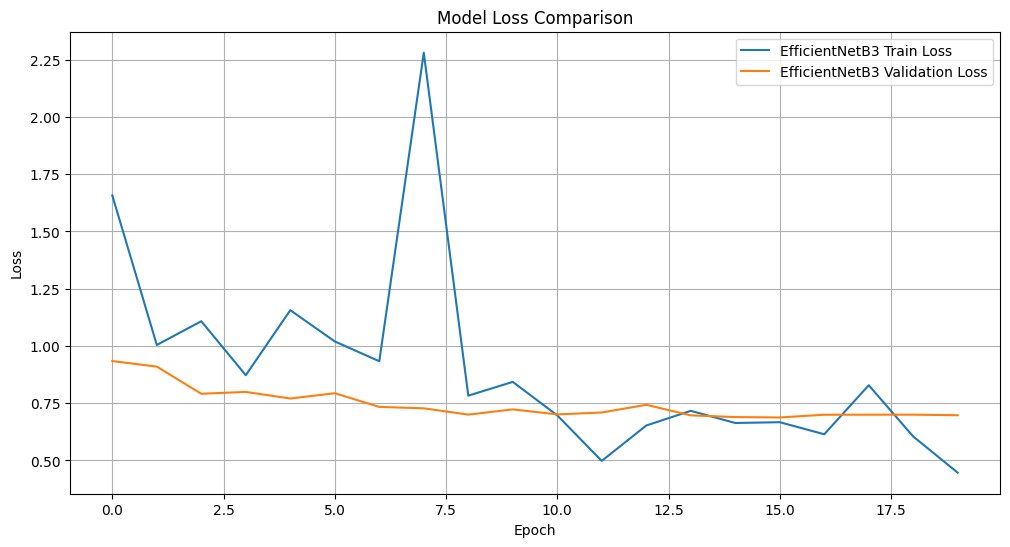

In [18]:
plt.figure(figsize=(12, 6))

# EfficientNetB3
plt.plot(history_1.history['loss'], label='EfficientNetB3 Train Loss')
plt.plot(history_1.history['val_loss'], label='EfficientNetB3 Validation Loss')
plt.title('Model Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.grid(True)
plt.show()